# Step 1: Load, normalise, and filter LLM data
### This turns it into the dataframe filtered_data, which has already had a filtered applied using fuzzywuzzy threshold 90 to remove duplicate rows

In [59]:
import pandas as pd
import re
from datetime import datetime
from fuzzywuzzy import fuzz
from IPython.display import display


# Load the data
data_path = 'Datasets/oldtimey touringbot version 2/SD_DN_AB_1908_v2.json'
data = pd.read_json(data_path)

# Function to normalize dates using regex
def normalize_date(date):
    try:
        if date == "UNKNOWN":
            return pd.NA  # Return NaN when the date is "UNKNOWN"
        
        if isinstance(date, str):
            if re.match(r'\d{2}\.\d{2}\.\d{2}', date):  # Format: DD.MM.YY
                date_obj = datetime.strptime(date, '%d.%m.%y')
                if date_obj.year >= 2000:
                    date_obj = date_obj.replace(year=date_obj.year - 100)
            elif re.match(r'\d{4}\.\d{2}\.\d{2}', date):  # Format: YYYY.MM.DD
                date_obj = datetime.strptime(date, '%Y.%m.%d')
            elif re.match(r'\d{2}\.\d{2}\.\d{4}', date):  # Format: DD.MM.YYYY
                date_obj = datetime.strptime(date, '%d.%m.%Y')
            else:
                return pd.NA  # Return NaN for unsupported or unmatched formats
        elif isinstance(date, datetime):
            date_obj = date
        else:
            return pd.NA  # Return NaN for unsupported types
        
        return date_obj.strftime('%Y-%m-%d')  # Convert to "YYYY-MM-DD"
    except ValueError:
        return pd.NA  # Return NaN on parsing errors

# Apply normalization and filter out invalid entries
data['normalized_date'] = data['konsert_datum'].apply(normalize_date)
data = data[data['normalized_date'].notna()]  # Keeps only valid dates

# Normalize the 'konsert_namn' field
data['normalized_konsert_namn'] = data['konsert_namn'].str.strip().str.lower()

# Identify duplicates
duplicates = data.duplicated(subset=['normalized_date', 'normalized_konsert_namn'], keep=False)
unique_data = data[~duplicates]
duplicate_data = data[duplicates]

# Combine the entries with invalid dates and duplicates for discarding
combined_discards = pd.concat([duplicate_data, data[data['normalized_date'].isna()]])

# Save the duplicates and invalid entries
today_date = datetime.now().strftime('%Y-%m-%d')
combined_discards.to_json(f'Cleaning/{today_date}_rejected_step_1.json', orient='records', force_ascii=False)

# Output the result (for verification purposes)
print(f"Unique records: {len(unique_data)}")
print(f"Discarded records: {len(combined_discards)}")

# Merge 'Producer' and 'Arrangör' columns, prioritize 'Producer' if both columns have data
try:
    data['Producer'] = data['Producer'].combine_first(data['Arrangör'])
except KeyError as e:
    print(f"Warning: The column '{e.args[0]}' does not exist in the DataFrame.")

# Check if 'Arrangör' column exists before trying to drop it
if 'Arrangör' in data.columns:
    data.drop(columns=['Arrangör'], inplace=True)
else:
    print("Warning: The column 'Arrangör' does not exist in the DataFrame, so it cannot be dropped.")

# Function to filter similar rows
def filter_similar_rows(df, date_column='normalized_date', threshold=90):
    grouped = df.groupby(date_column)
    to_discard = set()

    for _, group in grouped:
        rows = group.apply(lambda row: ' '.join(row.astype(str)), axis=1)
        for i in range(len(rows)):
            if rows.index[i] in to_discard:
                continue
            for j in range(i + 1, len(rows)):
                if rows.index[j] in to_discard:
                    continue
                if fuzz.ratio(rows.iloc[i], rows.iloc[j]) > threshold:
                    to_discard.add(rows.index[j])

    passed_indices = [idx for idx in df.index if idx not in to_discard]
    passed = df.loc[passed_indices]

    return passed, len(to_discard), len(passed)

# Apply the function to filter similar rows
filtered_data, num_discarded, num_passed = filter_similar_rows(data, threshold=90)

# Output the counts
print(f"Number of rows discarded: {num_discarded}")
print(f"Number of rows passed to the next step: {num_passed}")

# Function to normalize text
def normalize(text):
    if not isinstance(text, str):
        return text
    if pd.isna(text) or text.strip().lower() == "unknown":
        return ""
    text = text.lower()
    text = re.sub(r'[-,]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

##### Now dealing with human data
# Load the Excel file of human_data
human_data = pd.read_excel('All_Concerts_1908_filtered.xlsx')

# Normalize dates and concert names in human_data
human_data['normalized_date'] = human_data['konsert_datum'].apply(normalize_date)
human_data['normalized_konsert_namn'] = human_data['konsert_namn'].str.strip().str.lower()

# Drop the column 'Producer'
human_data.drop(columns=['Producer'], inplace=True)

# Rename the column 'Arrangör' to 'Producer'
human_data.rename(columns={'Arrangör': 'Producer'}, inplace=True)

# Normalize filtered_data
filtered_data = filtered_data.applymap(lambda x: normalize(x) if isinstance(x, str) else x)

# Normalize human_data if needed
human_data = human_data.applymap(lambda x: normalize(x) if isinstance(x, str) else x)

# Find common columns between the two DataFrames
common_columns = human_data.columns.intersection(filtered_data.columns)

# Reorder columns in human_data based on the order in filtered_data
human_data = human_data[common_columns]

# Define specific columns to compare
columns_to_compare = ['normalized_date', 'normalized_konsert_namn', 'lokal_namn', 'Producer']

# Drop columns not in columns_to_compare
human_data = human_data[columns_to_compare]
filtered_data = filtered_data[columns_to_compare]

# Preprocess human_data to group by 'normalized_date'
date_groups = human_data.groupby('normalized_date').apply(
    lambda df: df[columns_to_compare].dropna().to_dict('records')
)

# Display the filtered_data DataFrame
display(filtered_data)

display(human_data)


Unique records: 947
Discarded records: 135
Number of rows discarded: 97
Number of rows passed to the next step: 985


/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_98566/45281202.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  filtered_data = filtered_data.applymap(lambda x: normalize(x) if isinstance(x, str) else x)
/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_98566/45281202.py:130: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  human_data = human_data.applymap(lambda x: normalize(x) if isinstance(x, str) else x)
/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_98566/45281202.py:146: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  date_groups = human_data.groupby('normalized_date').apply(


,normalized_date,normalized_konsert_namn,lokal_namn,Producer
0,1908 02 14,vivien chartres afskedskonsert,kungliga musikaliska akademiens lokal,gellin eduard
1,1908 02 13,kullor ållon konsert,restaurang metr,
2,1908 02 13,stop konsert,sveasalen,
3,1908 01 18,konsert för wennerbergsstoden i uppsala,kfum:s stora hörsal,stockholms borgarskola
5,1908 01 19,kyrko konsert,gustaf wasa kyrkan,gellin eduard
...,...,...,...,...
1194,1908 09 06,circus orlando,circus orlando,
1195,1908 09 06,schwarzmanoffs orkester konsert,mosebacke,
1196,1908 09 06,konsert af solist kapellet freya,strömparterren,freya solist kapellet
1197,1908 09 06,middags & aftonkonsert,restaurant rosenbad,


,normalized_date,normalized_konsert_namn,lokal_namn,Producer
0,1908 01 02,brüssel kvartetten beethovenafton,kungliga musikaliska akademiens lokal,brüssel stråkkvartetten
1,1908 01 05,1:sta säsångskonsert: nordisk afton,hotel continentals festsal,gellin eduard
2,1908 01 05,afskedskonsert,immanuelskyrkan,bohlin carl. direktör
3,1908 01 05,folk konsert,arbetare institutet klara norra kyrkogata 8,NaN
4,1908 01 05,populärkonsert,vetenskapsakademiens hörsal,hansson axel
...,...,...,...,...
509,1908 12 26,familje soiré,vetenskapsakademiens hörsal,lundberg anna
510,1908 12 26,populär soaré,arbetare institutet klara norra kyrkogata 8,dahlberg erik
511,1908 12 27,populär soaré,arbetare institutet klara norra kyrkogata 8,dahlberg erik
512,1908 12 31,nyårsvaka å runan,NaN,NaN


# Human_Data: Comparing every row of human_data to LLM to find best match

In [60]:
from fuzzywuzzy import fuzz
import pandas as pd
import numpy as np

# Ensure both DataFrames only have the columns to compare and normalized_date
required_columns = columns_to_compare
assert all(col in filtered_data.columns for col in required_columns), "Missing required columns in filtered_data"
assert all(col in human_data.columns for col in required_columns), "Missing required columns in human_data"

filtered_data = filtered_data[required_columns]
human_data = human_data[required_columns]

# Ensure the 'normalized_date' column is 1-dimensional and properly formatted
filtered_data['normalized_date'] = pd.to_datetime(filtered_data['normalized_date'], errors='coerce')
human_data['normalized_date'] = pd.to_datetime(human_data['normalized_date'], errors='coerce')

# Drop rows with invalid 'normalized_date' values
filtered_data = filtered_data.dropna(subset=['normalized_date'])
human_data = human_data.dropna(subset=['normalized_date'])

# Function to compute the maximum fuzzy match score and index for a given row against a group of rows
def compute_fuzzy_match_with_date(row1_str, date_group, group_indices):
    max_score = 0
    best_index = None
    for idx, row2_str in zip(group_indices, date_group):
        score = fuzz.token_set_ratio(row1_str, row2_str)
        if score > max_score:
            max_score = score
            best_index = idx
    return (max_score if max_score > 0 else np.nan, best_index)

# Preprocess filtered_data to group by 'normalized_date'
date_groups = filtered_data.groupby('normalized_date').apply(
    lambda df: (
        [' '.join(map(str, [row[col] for col in columns_to_compare if col in row])) for _, row in df.iterrows()],
        df.index.tolist()
    )
)

# Compute match scores and best match indices for each row in human_data
human_data['match_score'], human_data['best_match_index'] = zip(*human_data.apply(
    lambda row: compute_fuzzy_match_with_date(
        ' '.join(map(str, [row[col] for col in columns_to_compare if col in row])),
        *date_groups.get(row['normalized_date'], ([], []))
    ),
    axis=1
))

# Print the match_score and best_match_index columns from human_data to show results
print(human_data[['match_score', 'best_match_index']])


/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_98566/3878022222.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  date_groups = filtered_data.groupby('normalized_date').apply(


     match_score  best_match_index
0           74.0             429.0
1           90.0             425.0
2           53.0              94.0
3           68.0             940.0
4           90.0              94.0
..           ...               ...
509          NaN               NaN
510          NaN               NaN
511          NaN               NaN
512         70.0             539.0
513         68.0             540.0

[514 rows x 2 columns]


# Statistics for the Human_data, detailing how close a match in the LLM data has been found

#### Best score so far is 69.75 achieved by comparing 'normalized_date', 'normalized_konsert_namn', 'lokal_namn', so if it's lower than that then you better have a good reason

Average of 'match_score': 70.24425287356321
25th Percentile of 'match_score': 54.0
Median (50th Percentile) of 'match_score': 67.0
75th Percentile of 'match_score': 87.0
Median of 'match' score': 67.0
Standard Deviation of 'match_score': 18.966847954845072


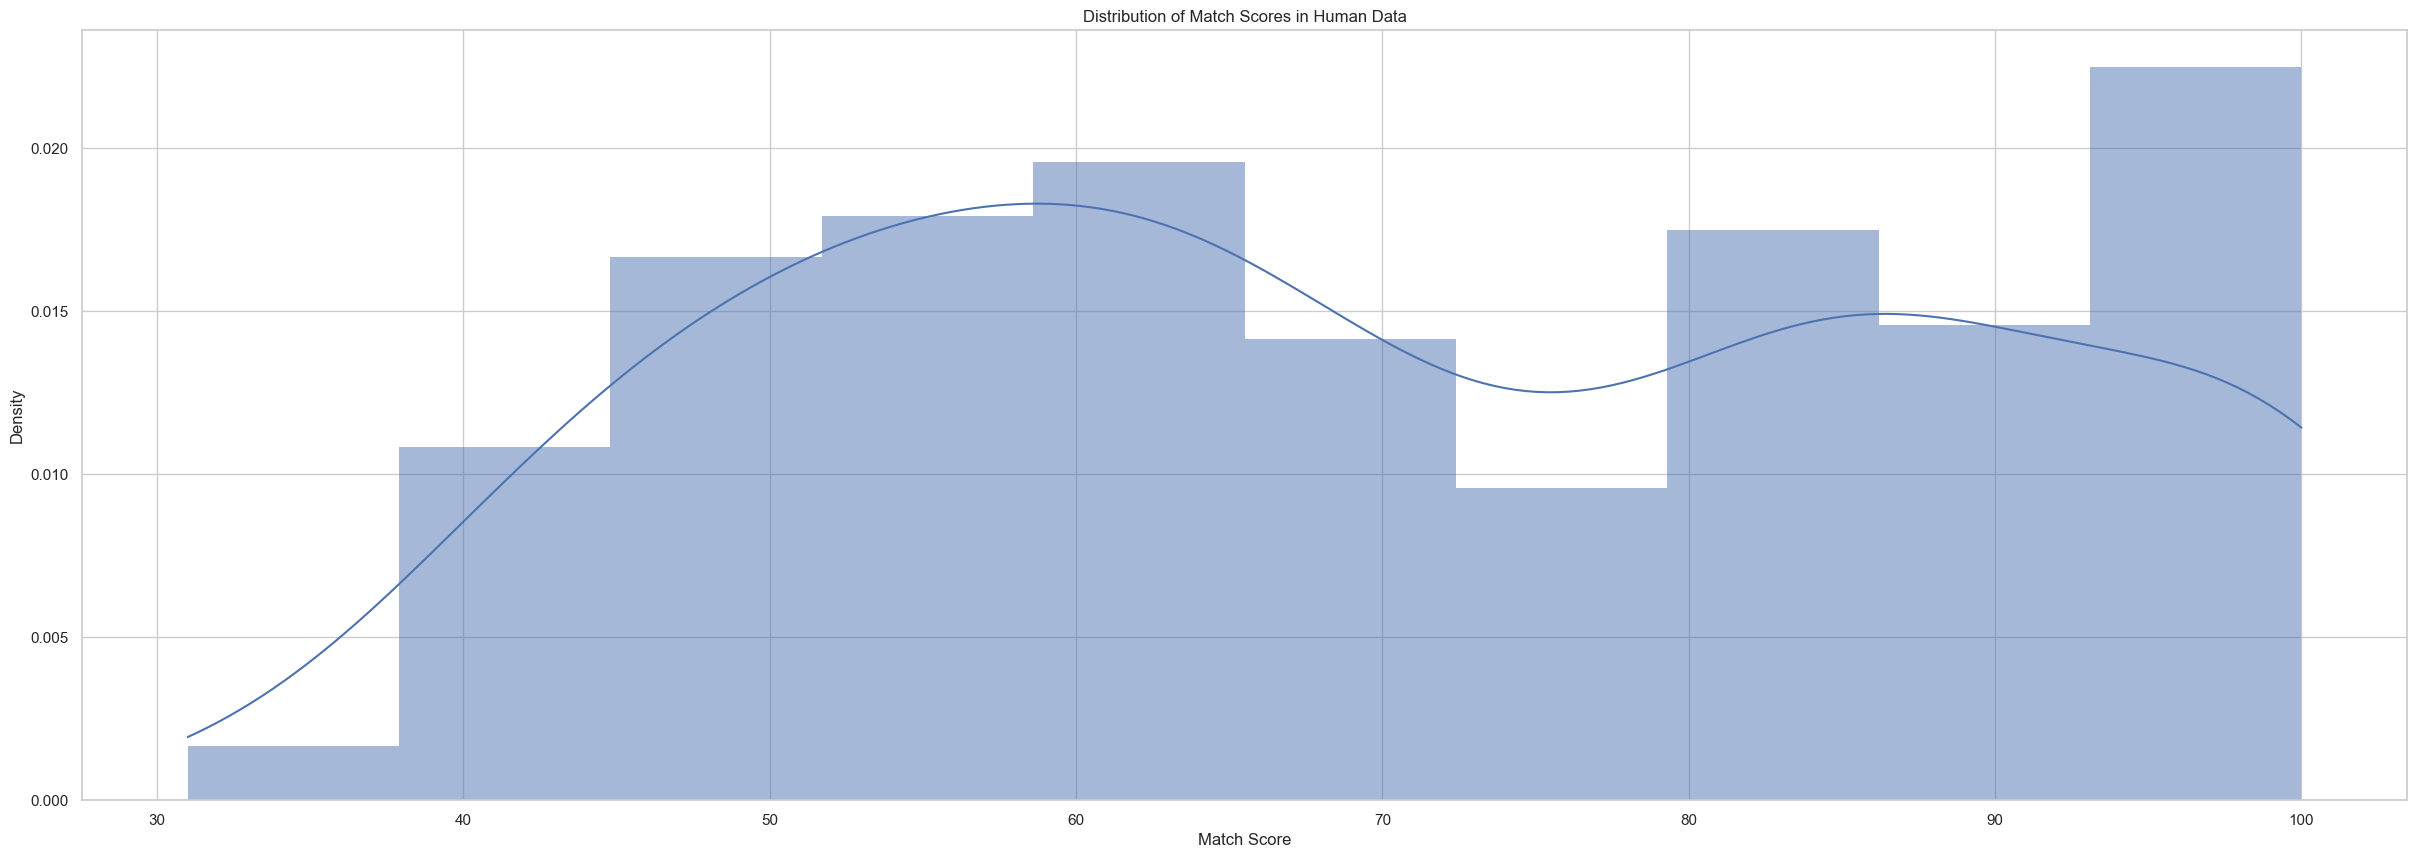

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the standard deviation of the 'match_score' column in human_data
std_deviation = human_data['match_score'].std()

# Calculate the average of the 'match_score' column in human_data
average_match_score = human_data['match_score'].mean()

# Print the average match score
print("Average of 'match_score':", average_match_score)

# Calculate specific percentiles of the 'match_score' column in human_data
percentile_25 = human_data['match_score'].quantile(0.25)
percentile_50 = human_data['match_score'].quantile(0.50)  # This is the median
percentile_75 = human_data['match_score'].quantile(0.75)

# Print the percentile values
print("25th Percentile of 'match_score':", percentile_25)
print("Median (50th Percentile) of 'match_score':", percentile_50)
print("75th Percentile of 'match_score':", percentile_75)

# Calculate the median of the 'match_score' column in human_data
median_match_score = human_data['match_score'].median()

# Print the median match score
print("Median of 'match' score':", median_match_score)

# Print the standard deviation
print("Standard Deviation of 'match_score':", std_deviation)

# Setting the style and color palette of the plot
sns.set(style="whitegrid")

# Creating the density plot for match_score distribution in human_data
plt.figure(figsize=(30, 10))
sns.histplot(human_data['match_score'], kde=True, stat="density", linewidth=0)

# Adding titles and labels
plt.title('Distribution of Match Scores in Human Data')
plt.xlabel('Match Score')
plt.ylabel('Density')

# Display the plot
plt.show()


# Statistics for comparisons finding best human_data match for LLM data

In [44]:
# Calculate the standard deviation of the 'match_score' column
std_deviation = filtered_data['match_score'].std()

# Calculate the average of the 'match_score' column
average_match_score = filtered_data['match_score'].mean()

# Print the average match score
print("Average of 'match_score':", average_match_score)

# Calculate specific percentiles of the 'match_score' column
percentile_25 = filtered_data['match_score'].quantile(0.25)
percentile_50 = filtered_data['match_score'].quantile(0.50)  # This is the median
percentile_75 = filtered_data['match_score'].quantile(0.75)

# Print the percentile values
print("25th Percentile of 'match_score':", percentile_25)
print("Median (50th Percentile) of 'match_score':", percentile_50)
print("75th Percentile of 'match_score':", percentile_75)

# Calculate the median of the 'match_score' column
median_match_score = filtered_data['match_score'].median()

# Print the median match score
print("Median of 'match_score':", median_match_score)


# Print the standard deviation
print("Standard Deviation of 'match_score':", std_deviation)


KeyError: 'match_score'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Setting the style and color palette of the plot
sns.set(style="whitegrid")

# Creating the density plot
plt.figure(figsize=(30, 10))
sns.histplot(filtered_data['match_score'], kde=True, stat="density", linewidth=0)

# Adding titles and labels
plt.title('Distribution of Match Scores')
plt.xlabel('Match Score')
plt.ylabel('Density')

# Display the plot
plt.show()


# LLM: This concatenates everything in filtered_data into a string then compares

In [ ]:

from fuzzywuzzy import fuzz
import pandas as pd

# Define a function to compute fuzzy match score between two rows, using only selected columns
def compute_fuzzy_match(row1, human_data):
    # Convert selected entries to string and concatenate
    row1_str = ' '.join(map(str, row1[columns_to_compare]))
    
    max_score = 0  # Initialize max score
    
    # Loop over each row in human_data to find the highest match score
    for index, row2 in human_data.iterrows():
        # Concatenate only the selected columns for comparison
        row2_str = ' '.join(map(str, row2[columns_to_compare]))
        score = fuzz.ratio(row1_str, row2_str)  # Compute the match score
        #print(row1_str,row2_str)
        if score > max_score:
            max_score = score  # Update the max score if current score is higher
    
    return max_score

# Apply the function row-wise and create a new column for scores in filtered_data
filtered_data['match_score'] = filtered_data.apply(compute_fuzzy_match, axis=1, args=(human_data,))

# Display the updated filtered_data DataFrame
print(filtered_data)


# LLM filtered_data Analysis: groups by date then concatenates and matches

In [ ]:

from fuzzywuzzy import fuzz
import pandas as pd
import numpy as np

def compute_fuzzy_match_with_date(row1_str, date_group):
    max_score = 0
    for row2_str in date_group:
        score = fuzz.ratio(row1_str, row2_str)
        if score > max_score:
            max_score = score
    return max_score if max_score > 0 else np.nan

# Preprocess human_data to group by 'normalized_date'
date_groups = human_data.groupby('normalized_date').apply(
    lambda df: [' '.join(map(str, [row[col] for col in columns_to_compare if col in row])) for _, row in df.iterrows()]
)

# Compute match scores
filtered_data['match_score'] = filtered_data.apply(
    lambda row: compute_fuzzy_match_with_date(
        ' '.join(map(str, [row[col] for col in columns_to_compare if col in row])),
        date_groups.get(row['normalized_date'], [])
    ),
    axis=1
)

print(filtered_data['match_score'])
